In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.plotting.register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


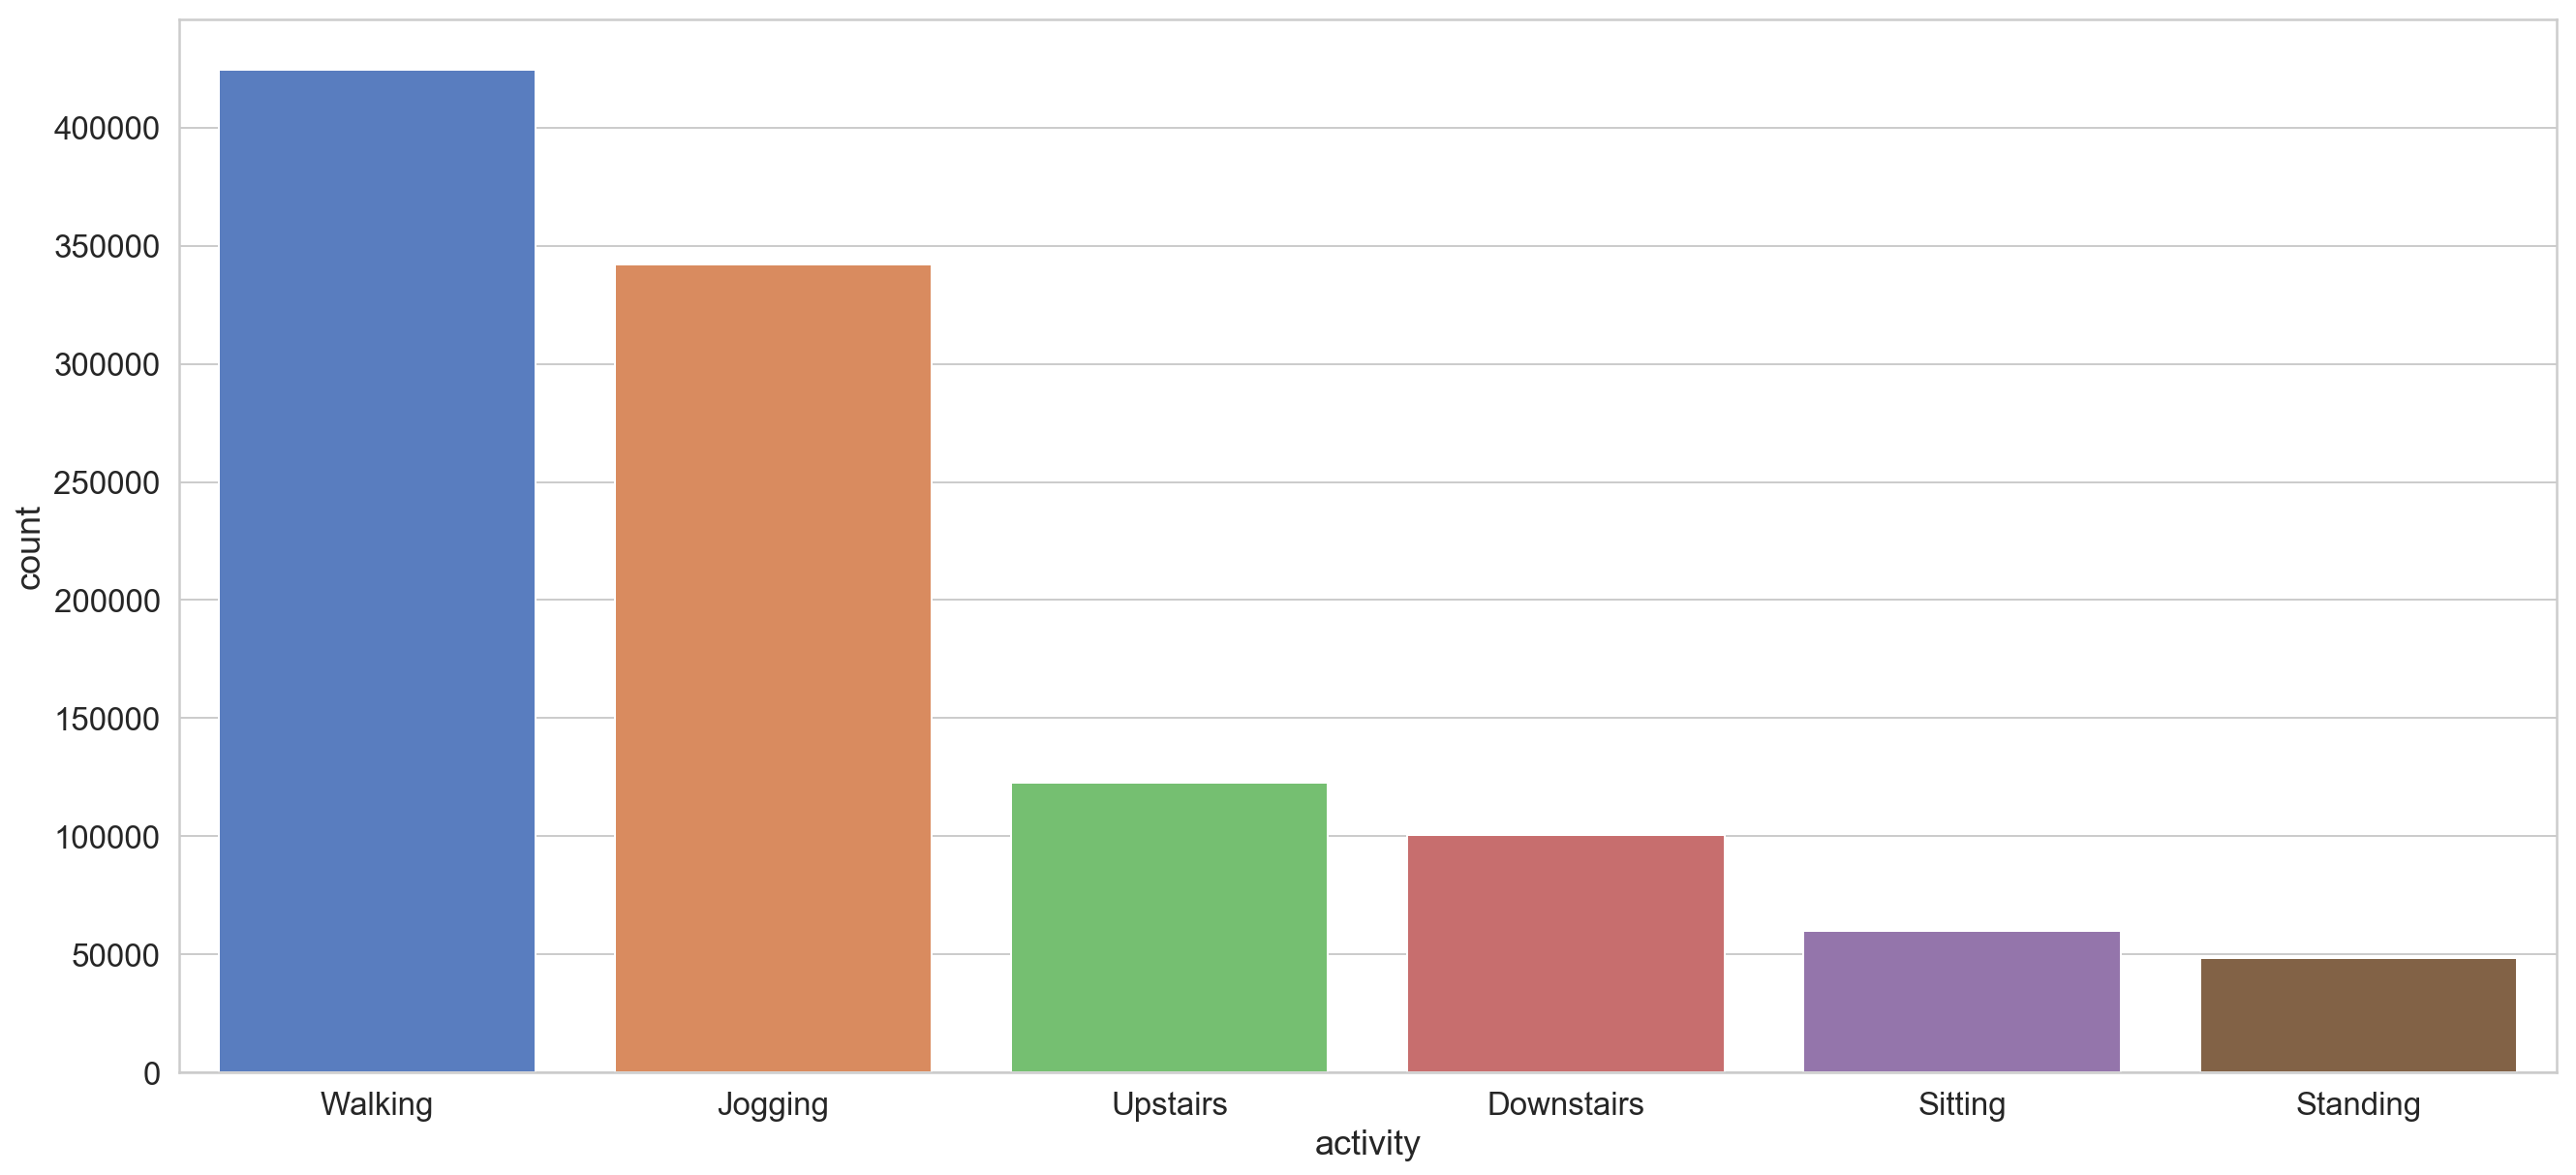

In [20]:

sns.countplot(x='activity', data=df, order=df.activity.value_counts().index)

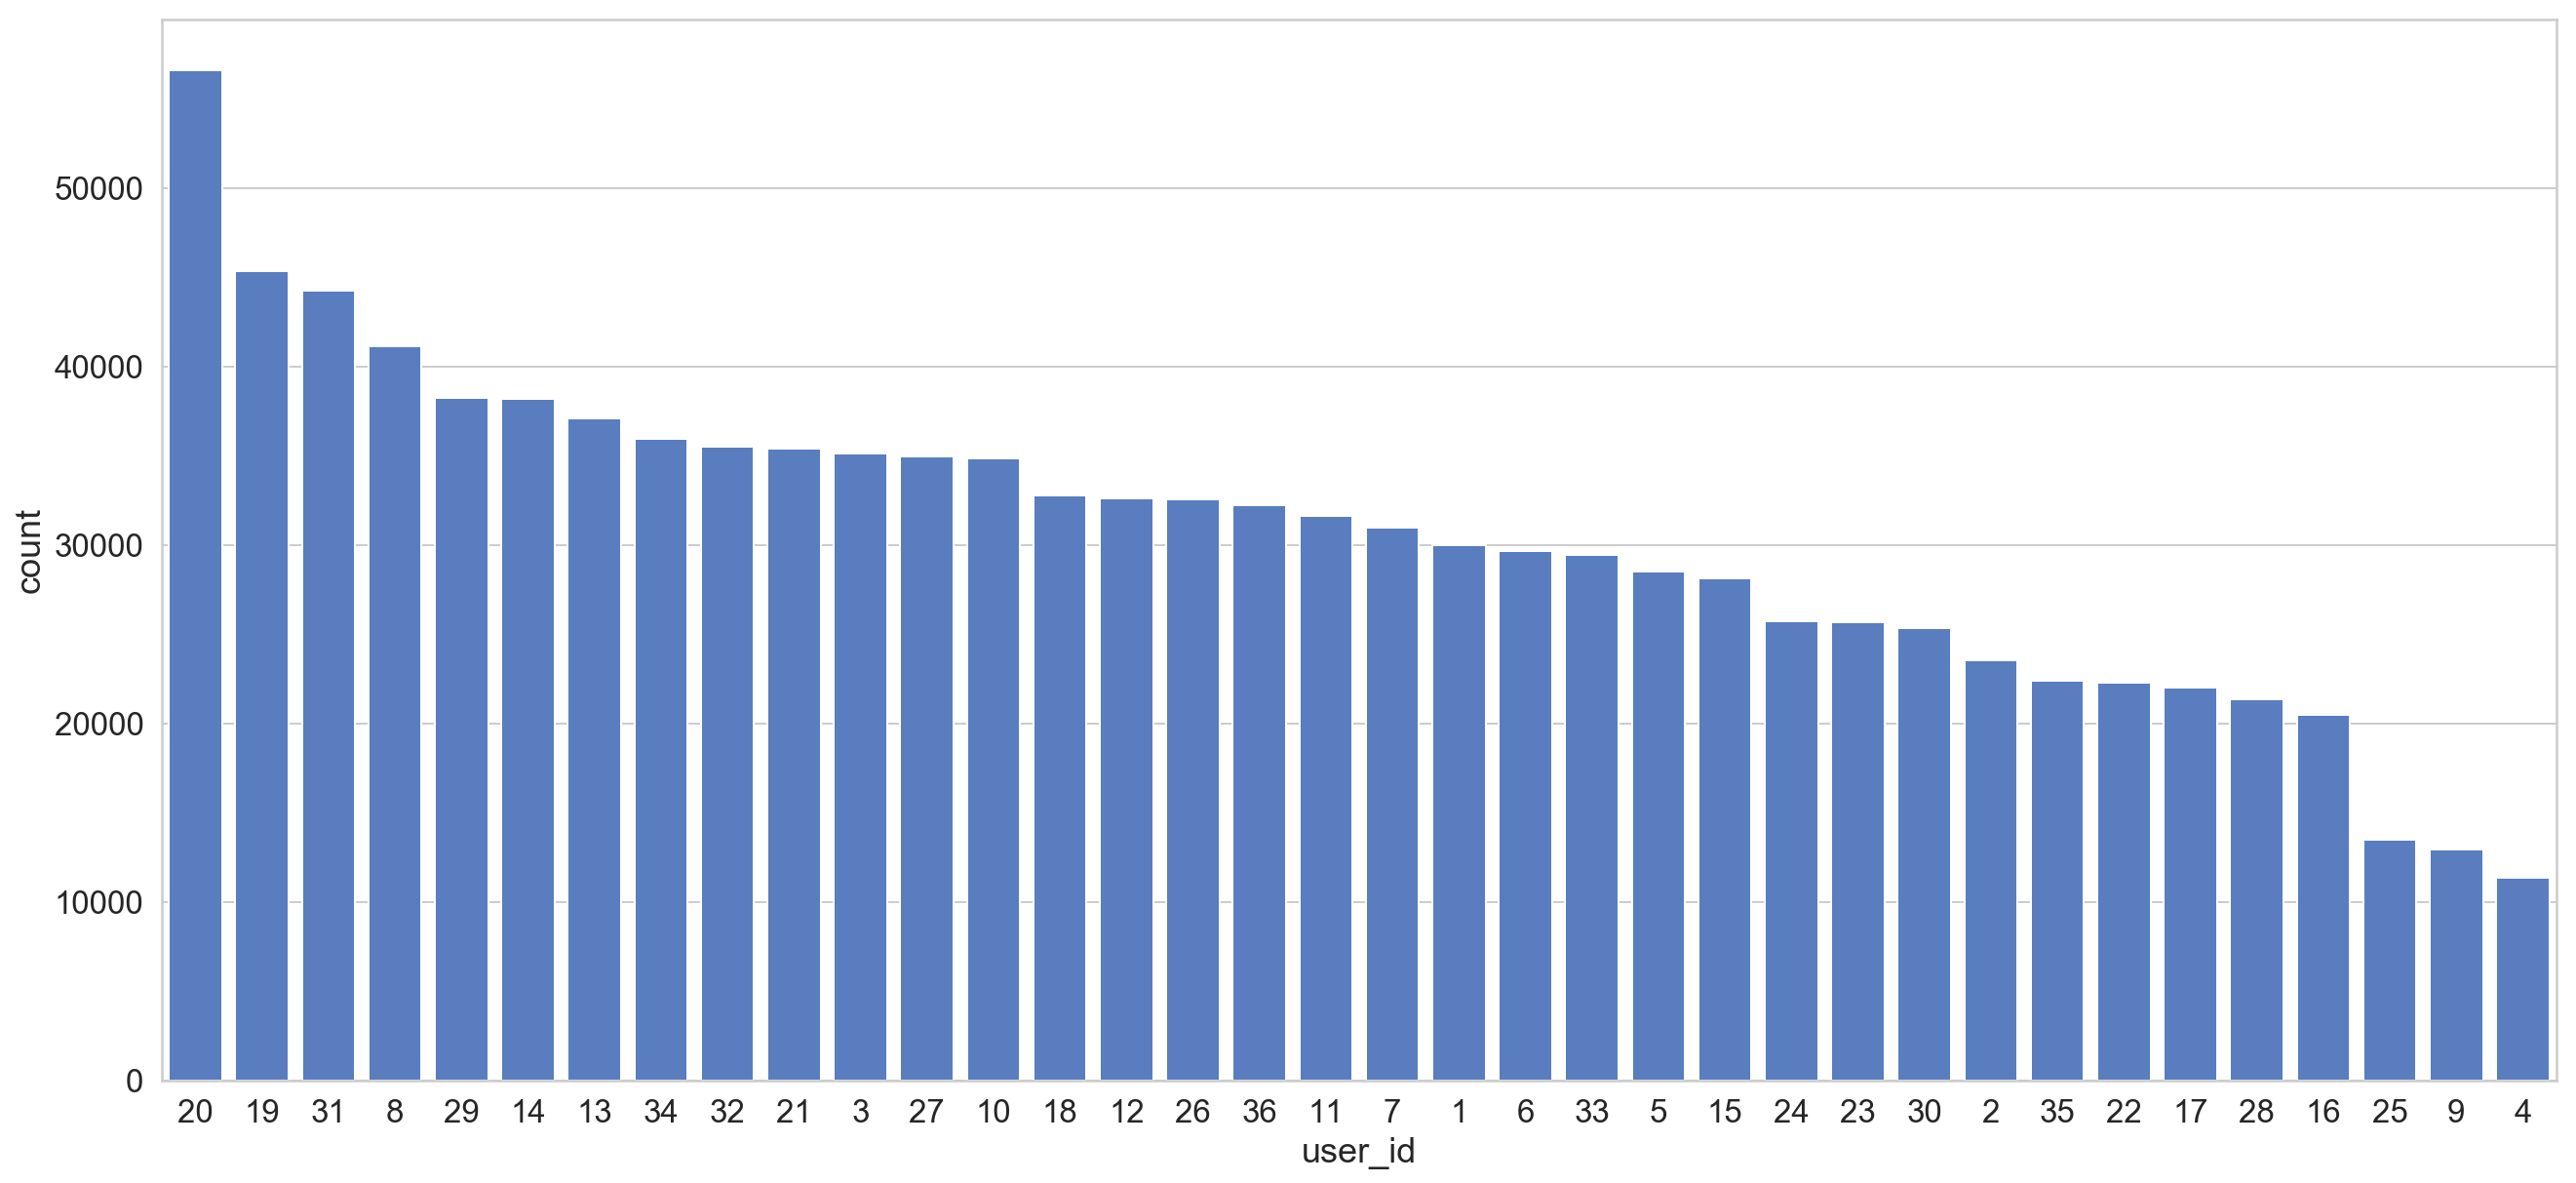

In [21]:
sns.countplot(x='user_id', data=df, palette=[sns.color_palette()[0]], order=df.user_id.value_counts().index)

In [22]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

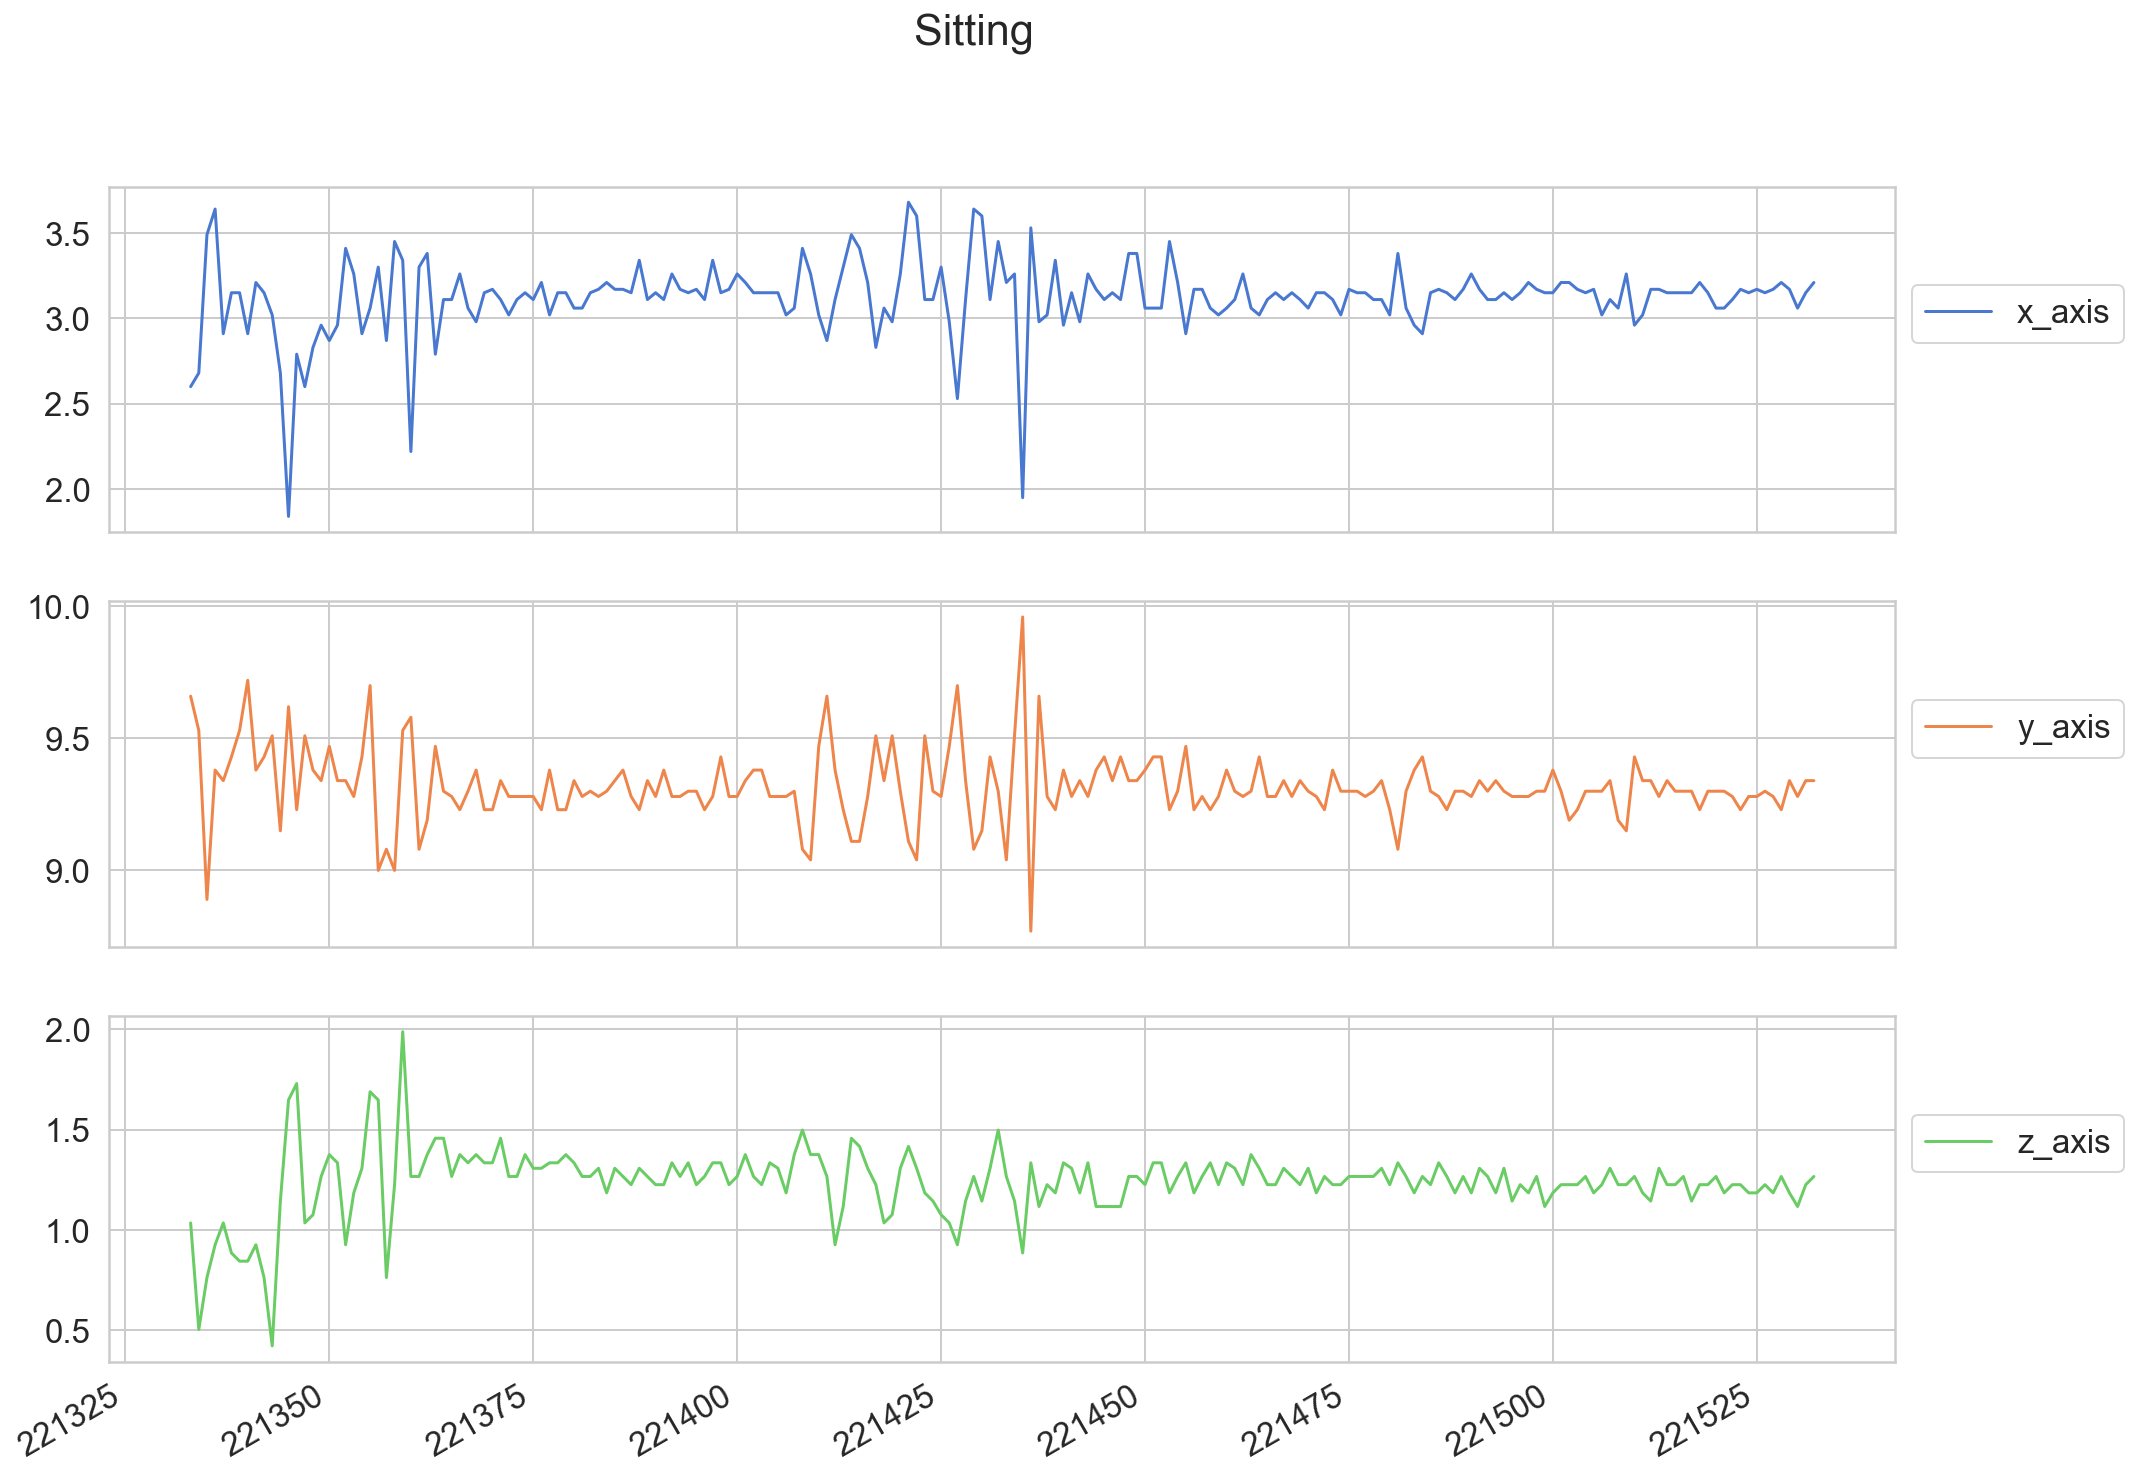

In [23]:
plot_activity('Sitting', df)


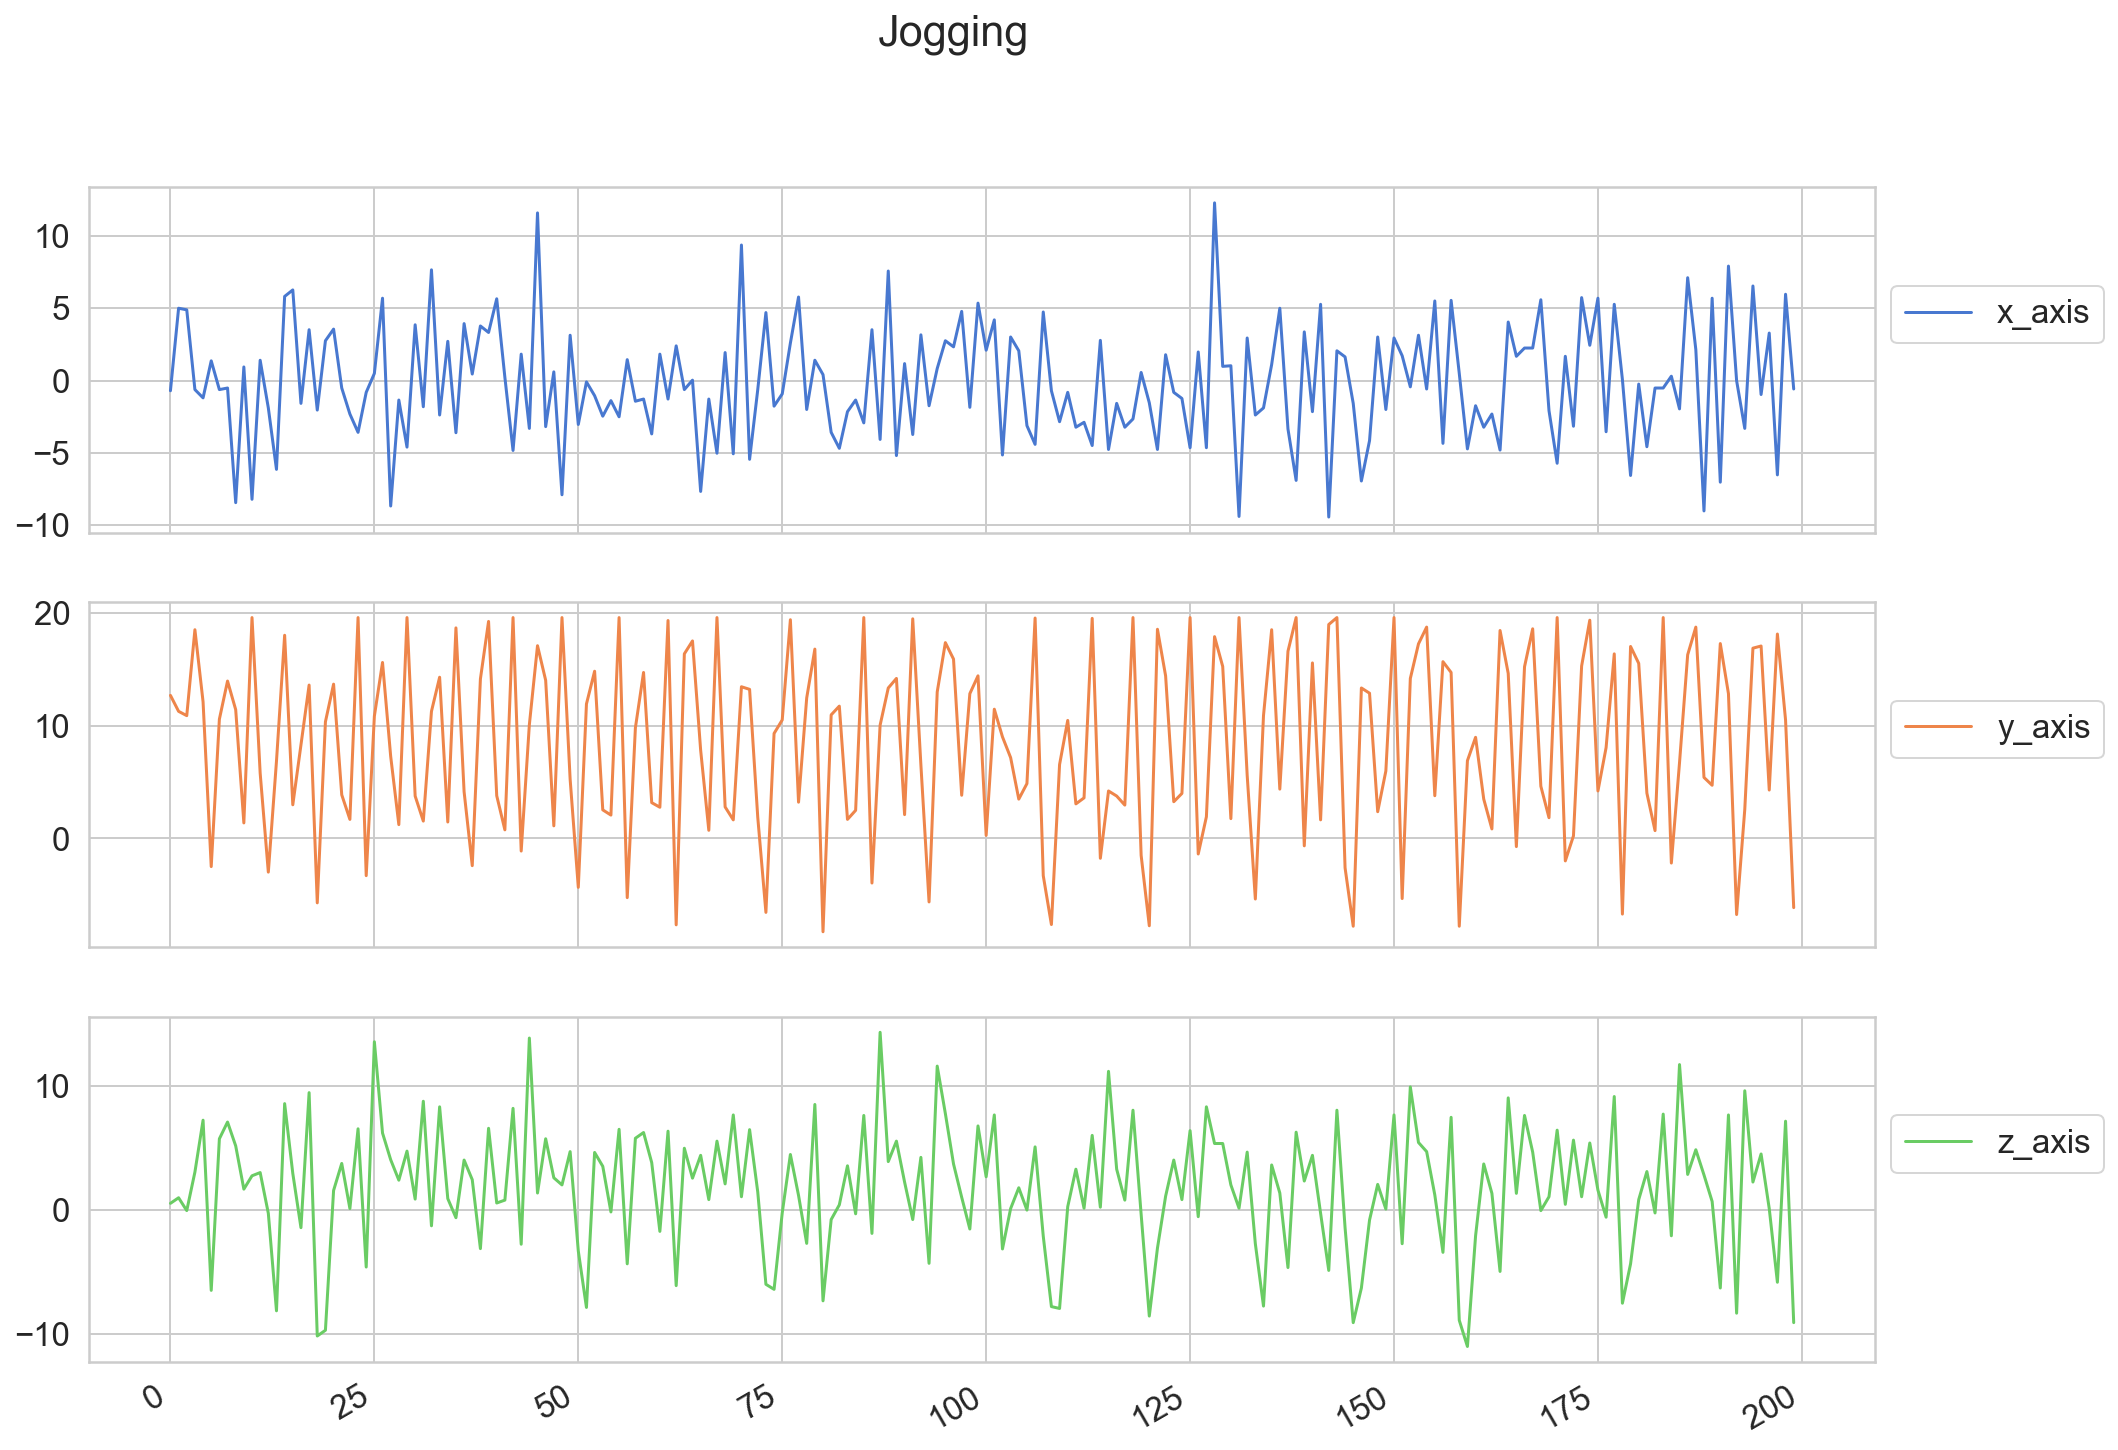

In [24]:
plot_activity('Jogging', df)

In [3]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [4]:
scale_columns = ['x_axis', 'y_axis', 'z_axis']
scaler = RobustScaler()
scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/Users/ayanpaul/Library/Python/3.6/lib/python/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/ayanpaul/Library/Python/3.6/lib/python/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
def create_dataset(X, y, time_steps=1, steps=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, steps):
        Xs.append(X.iloc[i: i + time_steps].values)
        ys.append(stats.mode(y.iloc[i: i + time_steps])[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [6]:
TIME_STEPS = 200
STEPS = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']],
    df_train.activity,
    time_steps=TIME_STEPS,
    steps=STEPS
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']],
    df_test.activity,
    time_steps=TIME_STEPS,
    steps=STEPS
)

In [7]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [12]:
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            units=128,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
)

model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
# model.summary()

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)


Train on 20208 samples, validate on 2246 samples
Epoch 1/30
20208/20208 [==============================] - 113s 6ms/sample - loss: 1.4414 - acc: 0.5103 - val_loss: 1.1687 - val_acc: 0.6305